<a href="https://colab.research.google.com/github/mcmau/Dados/blob/master/Credit_card_Fraud_detection_using_GNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
ealtman2019_credit_card_transactions_path = kagglehub.dataset_download('ealtman2019/credit-card-transactions')

print('Data source import complete.')

ealtman2019_credit_card_transactions_path

Data source import complete.


'/kaggle/input/credit-card-transactions'

## ML for graph

These are the general steps of ML on Graph, depending on the task, the methods used in each step may change and not all the steps may be needed.

1. Graph Representation: The first step in applying machine learning techniques to graphs is to represent the graph in a format that can be input into a machine learning model. This can be done using various graph representations such as adjacency matrices, adjacency lists, and edge lists.

2. Feature Extraction: Once the graph is represented, the next step is to extract features from the graph that can be used as input to a machine learning model. These features can include things like node degree, centrality measures, and graph traversal patterns.

3. Dimensionality Reduction: As the number of nodes and edges in a graph can be large, it is often necessary to reduce the dimensionality of the graph representation before applying machine learning techniques. This can be done using techniques like principal component analysis (PCA) and t-SNE.

4. Model Selection: After the graph is represented and features have been extracted, the next step is to select a machine learning model that can be applied to the graph data. Common models used for graph data include decision trees, random forests, and neural networks.

5. Training and Evaluation: Once the model is selected, it is trained on the graph data using a labeled training dataset. The model is then evaluated on a separate test dataset to assess its performance.

6. Predictions: After the model is trained, it can be used to make predictions on new graph data. For example, it can be used to predict the likelihood of a node in a graph being in a certain class or to predict the likelihood of a link between two nodes.

## Dataset
The IBM credit card transaction dataset is a publicly available dataset that contains information about credit card transactions. It is often used for research and testing of fraud detection models. The dataset includes a variety of features such as the amount of the transaction, the type of card used, and the location of the transaction. It also includes a label indicating whether or not the transaction was fraudulent. The dataset is designed to be representative of real-world transactions and therefore contains a certain level of class imbalance, with a higher number of non-fraudulent transactions than fraudulent transactions. The dataset is provided by IBM and the data is simulated, but it is not specified the exact process of data simulation. It is important to note that the data is not real and it is not linked to any real customer or financial institution.

The data set contains:
* 24 million unique transactions
* 6,000 unique merchants
* 100,000 unique cards
* 30,000 fraudulent samples (0.1% of total transactions)

Features:
 0   User            int64  
 1   Card            int64  
 2   Year            int64  
 3   Month           int64  
 4   Day             int64  
 5   Time            object
 6   Amount          object
 7   Use Chip        object
 8   Merchant Name   int64  
 9   Merchant City   object
 10  Merchant State  object
 11  Zip             float64
 12  MCC             int64  
 13  Errors?         object
 14  Is Fraud?       object



# INSTALLING REQUIRED LIBRARIES

In [2]:
pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.6 MB/s eta 0:00:00


# IMPORTING REQUIRED LIBRARIES

In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GAE
import networkx as nx
import seaborn as sns


# READING DATA AND PERFORMING EDA

In [4]:
d = pd.read_csv("/kaggle/input/credit-card-transactions/credit_card_transactions-ibm_v2.csv")
d

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?
0,0,0,2002,9,1,06:21,$134.09,Swipe Transaction,3527213246127876953,La Verne,CA,91750.0,5300,NaN,No
1,0,0,2002,9,1,06:42,$38.48,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No
2,0,0,2002,9,2,06:22,$120.34,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No
3,0,0,2002,9,2,17:45,$128.95,Swipe Transaction,3414527459579106770,Monterey Park,CA,91754.0,5651,NaN,No
4,0,0,2002,9,3,06:23,$104.71,Swipe Transaction,5817218446178736267,La Verne,CA,91750.0,5912,NaN,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24386895,1999,1,2020,2,27,22:23,$-54.00,Chip Transaction,-5162038175624867091,Merrimack,NH,3054.0,5541,NaN,No
24386896,1999,1,2020,2,27,22:24,$54.00,Chip Transaction,-5162038175624867091,Merrimack,NH,3054.0,5541,NaN,No
24386897,1999,1,2020,2,28,07:43,$59.15,Chip Transaction,2500998799892805156,Merrimack,NH,3054.0,4121,NaN,No
24386898,1999,1,2020,2,28,20:10,$43.12,Chip Transaction,2500998799892805156,Merrimack,NH,3054.0,4121,NaN,No


In [5]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24386900 entries, 0 to 24386899
Data columns (total 15 columns):
 #   Column          Dtype  
---  ------          -----  
 0   User            int64  
 1   Card            int64  
 2   Year            int64  
 3   Month           int64  
 4   Day             int64  
 5   Time            object 
 6   Amount          object 
 7   Use Chip        object 
 8   Merchant Name   int64  
 9   Merchant City   object 
 10  Merchant State  object 
 11  Zip             float64
 12  MCC             int64  
 13  Errors?         object 
 14  Is Fraud?       object 
dtypes: float64(1), int64(7), object(7)
memory usage: 2.7+ GB


MessageError: Error: credential propagation was unsuccessful

Category counts:
 Is Fraud?
No     24357143
Yes       29757
Name: count, dtype: int64


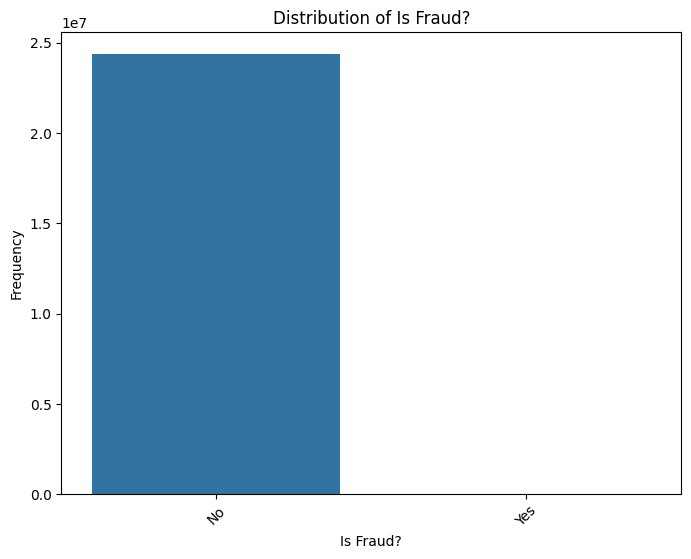

Category proportions:
 Is Fraud?
No     0.99878
Yes    0.00122
Name: proportion, dtype: float64


In [12]:

# Assuming you have a DataFrame 'df' and a categorical feature 'feature_name'
feature_name = 'Is Fraud?'

# 1. Frequency count of each category
category_counts = d[feature_name].value_counts()
print("Category counts:\n", category_counts)

# 2. Plot a bar plot of the categorical feature
plt.figure(figsize=(8, 6))
sns.countplot(x=d[feature_name])
plt.title(f'Distribution of {feature_name}')
plt.xlabel(feature_name)
plt.ylabel('Frequency')
plt.xticks(rotation=45)  # Rotate x-axis labels if they are long
plt.show()

# 3. Calculate and print the proportions of each category
category_proportions = d[feature_name].value_counts(normalize=True)
print("Category proportions:\n", category_proportions)


In [13]:
# Check the number of fraudulent transactions
d['Is Fraud?'].value_counts()

,count
Is Fraud?,
No,24357143
Yes,29757


In [4]:
# Check missing value by column
d.isnull().sum()

NameError: name 'd' is not defined

In [15]:
# We need to strip the '$' from the Amount to cast as a float
d["Amount"]=d["Amount"].str.replace("$","").astype(float)

In [3]:
# Now, we have transformed the datatype of Amount from object to float
d.Amount.head(5)

NameError: name 'd' is not defined

In [17]:
d.Time.head(5)

,Time
0,06:21
1,06:42
2,06:22
3,17:45
4,06:23


In [2]:
# Extract the hour and minute to perform a more refined time series analysis
d["Hour"] = d["Time"].str [0:2]
d["Minute"] = d["Time"].str [3:5]
d = d.drop(['Time'],axis=1)

NameError: name 'd' is not defined

In [ ]:
# change the is fraud column to binary
d["Is Fraud?"] = d["Is Fraud?"].apply(lambda x: 1 if x == 'Yes' else 0)

# STRATEGIC SAMPLING DUE TO HUGE CLASS-IMBALANCE

The fraudulent trasactions amount to nearly just one percent of the total transactions. So, ther is a huge class imbalance problem. A strategic sampling technique is used so as to maintain a reasonable balance of 30-70 between the two classes.

In [1]:

fraud_d = d[d['Is Fraud?'] == 'Yes']
nonfraud_d = d[d['Is Fraud?'] == 'No'].sample(n=70000, random_state=42)
df = pd.concat([fraud_d, nonfraud_d]).sample(frac=1, random_state=42)
df

NameError: name 'd' is not defined

In [ ]:
df2 = df
df2

# PRE-PROCESSING OF DATA

In [10]:


df["Amount"] = df["Amount"].replace('[\$,]', '', regex=True).astype(float)
df["Is Fraud?"] = df["Is Fraud?"].apply(lambda x: 1 if x == 'Yes' else 0)
df["Errors?"] = df["Errors?"].fillna("No error")
# df = df[df["Errors?"] != "No error"]
df["card_id"] = df["User"].astype(str) + "_" + df["Card"].astype(str)
df = df.drop(columns=["Time", "User", "Card", "Merchant State", "Zip"])
df["Merchant City"] = LabelEncoder().fit_transform(df["Merchant City"])
df["Use Chip"] = LabelEncoder().fit_transform(df["Use Chip"])

NameError: name 'df' is not defined

In [ ]:
df

In [ ]:
df["Errors?"] = LabelEncoder().fit_transform(df["Errors?"])
df

## code to normalize year, month, day, amount,merchant city,mcc,

In [ ]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import pandas as pd

# Assuming df is your DataFrame
# Step 1: Normalize numeric columns (e.g., 'year', 'month', 'day', 'amount')
numeric_columns = ['Year', 'Month', 'Day', 'Amount']

scaler = MinMaxScaler()  # You can use StandardScaler() if you want Z-score normalization
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

# Step 2: Encode categorical columns (e.g., 'Merchant City' and 'MCC')
# Use LabelEncoder for simplicity; One-Hot Encoding can be used if needed
df['Merchant City'] = LabelEncoder().fit_transform(df['Merchant City'])
df['MCC'] = LabelEncoder().fit_transform(df['MCC'])

# Optional: If you want to apply One-Hot Encoding, you can use:
# df = pd.get_dummies(df, columns=['Merchant City', 'MCC'], drop_first=True)

# Step 3: Check the resulting DataFrame
print(df.head())


In [ ]:
df['Merchant Name'] = LabelEncoder().fit_transform(df['Merchant Name'])
df

In [ ]:
df.head(10)

In [ ]:
# import os

# # List all files in /kaggle/working/
# for file in os.listdir('/kaggle/working'):
#     print(file)


# Graph Construction

In [ ]:
# Build graph
G = nx.MultiGraph()
# G= nx.
G.add_nodes_from(df["card_id"].unique(), type='card')
G.add_nodes_from(df["Merchant Name"].unique(), type='merchant')
node_mapping = {node: idx for idx, node in enumerate(G.nodes)}

total_edges = []
edge_attrs = []
labels = []
for _, row in df.iterrows():
    src = node_mapping[row["card_id"]]
    dst = node_mapping[row["Merchant Name"]]
    total_edges.append((src, dst))
    edge_attrs.append([row["Amount"], row["Merchant City"], row["Use Chip"],row["Year"],row["Month"],row["Day"],row["Errors?"]])
    labels.append(row["Is Fraud?"])

edge_index = torch.tensor(np.array(total_edges).T, dtype=torch.long)
edge_attr = torch.tensor(edge_attrs, dtype=torch.float)
labels = torch.tensor(labels, dtype=torch.long)
x = torch.eye(len(node_mapping))

data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=labels)

# Train-test split
data_train, data_test = train_test_split(
    list(range(data.edge_index.shape[1])), test_size=0.2, random_state=42, stratify=labels
)
train_mask = torch.zeros(data.edge_index.shape[1], dtype=torch.bool)
train_mask[data_train] = True
test_mask = torch.zeros(data.edge_index.shape[1], dtype=torch.bool)
test_mask[data_test] = True

In [ ]:
print("Graph Information")
print("-" * 50)
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of edges: {data.num_edges}")
print(f"Node feature shape: {data.x.shape}")
print(f"Edge index shape: {data.edge_index.shape}")
print(f"Edge attribute shape: {data.edge_attr.shape}")
print(f"Edge label shape: {data.y.shape}")
print(f"Number of features per edge: {data.edge_attr.shape[1]}")
print(f"Number of classes: {data.y.unique().size(0)}")
print(f"Class distribution: {torch.bincount(data.y)}")
print(f"Training edges: {train_mask.sum().item()}")
print(f"Testing edges: {test_mask.sum().item()}")


In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import torch
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


# Cria o grafo
G = nx.MultiGraph()
G.add_nodes_from(d["card_id"].unique(), type='card')
G.add_nodes_from(d["Merchant Name"].unique(), type='merchant')
node_mapping = {node: idx for idx, node in enumerate(G.nodes)}

total_edges = []
edge_attrs = []
labels = []
for _, row in d.iterrows():
    src = node_mapping[row["card_id"]]
    dst = node_mapping[row["Merchant Name"]]
    total_edges.append((src, dst))
    edge_attrs.append([row["Amount"], row["Merchant City"], row["Use Chip"],row["Year"],row["Month"],row["Day"],row["Errors?"]])
    labels.append(row["Is Fraud?"])

edge_index = torch.tensor(np.array(total_edges).T, dtype=torch.long)
edge_attr = torch.tensor(edge_attrs, dtype=torch.float)
labels = torch.tensor(labels, dtype=torch.long)
x = torch.eye(len(node_mapping))

data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=labels)

# Train-test split
data_train, data_test = train_test_split(
    list(range(data.edge_index.shape[1])), test_size=0.2, random_state=42, stratify=labels
)
train_mask = torch.zeros(data.edge_index.shape[1], dtype=torch.bool)
train_mask[data_train] = True
test_mask = torch.zeros(data.edge_index.shape[1], dtype=torch.bool)
test_mask[data_test] = True


def plot_graph(graph, node_mapping, top_n=10):
    """
    Plota o grafo e exibe o número de conexões dos nós.

    Args:
        graph (nx.Graph): O grafo a ser plotado.
        node_mapping (dict): Um dicionário mapeando nós para seus índices.
        top_n (int): Número de nós com mais conexões a serem exibidos.
    """

    # Calcula o grau de cada nó (número de conexões)
    node_degrees = dict(graph.degree())

    # Ordena os nós por grau decrescente
    sorted_nodes = sorted(node_degrees.items(), key=lambda item: item[1], reverse=True)

    # Imprime os top_n nós com mais conexões
    print("\nTop {} Nodes by Number of Connections:".format(top_n))
    for node, degree in sorted_nodes[:top_n]:
        # Encontra o nome original do nó usando o node_mapping invertido
        original_node_name = list(node_mapping.keys())[list(node_mapping.values()).index(node)]
        print(f"Node: {original_node_name}, Connections: {degree}")

    # Layout do grafo (pode ajustar o layout para melhor visualização)
    pos = nx.spring_layout(graph, k=0.1)  # Ajuste o valor de 'k' para espaçamento

    # Desenha o grafo
    plt.figure(figsize=(12, 8))  # Ajuste o tamanho da figura
    nx.draw(graph, pos, with_labels=False, node_size=20, node_color='skyblue', edge_color='gray', alpha=0.7)

    # Adiciona rótulos apenas para alguns nós para evitar sobreposição
    labels = {node: name for name, node in node_mapping.items() if node in pos and node in [node for node, degree in sorted_nodes[:top_n]]} # Rótulos só para o top_n
    nx.draw_networkx_labels(graph, pos, labels, font_size=8, font_color='black')


    plt.title("Credit Card Transaction Graph")
    plt.show()



# Converte o grafo torch_geometric para networkx
G_nx = nx.MultiGraph()  # Usa MultiGraph para permitir múltiplas arestas

# Adiciona nós
for i in range(data.x.shape[0]):
    G_nx.add_node(i)

# Adiciona arestas
for i in range(data.edge_index.shape[1]):
    src = data.edge_index[0, i].item()
    dst = data.edge_index[1, i].item()
    # Adiciona os atributos como um dicionário
    G_nx.add_edge(src, dst, attr_dict=data.edge_attr[i].tolist())  # Transforma o tensor em lista


# Chama a função para plotar o grafo
plot_graph(G_nx, node_mapping)

NameError: name 'd' is not defined

![screenshot_221639.png](attachment:210c7e19-25aa-415a-842e-202605d57e22.png)

The visual representation of the constructed graph in [Gephi](https://gephi.org/).  Black nodes represent cardholders, Brown nodes represent merchants, and red edges indicate fraudulent transactions while Green edges represent legitimate transactions.
        The graph reveals clusters and transaction patterns which are later used for GNN-based classification.

In [ ]:
# import networkx as nx
# from torch_geometric.utils import to_networkx

# # Create an empty graph (undirected for visualization)
# G_export = nx.Graph()

# # Add nodes from the data and distinguish between user and merchant nodes
# for idx in range(data.num_nodes):
#     G_export.add_node(idx)

# # Create node type mapping (0 - card, 1 - merchant) based on your assumption
# node_types = {}
# for _, row in df.iterrows():
#     card_id = row["card_id"]
#     merchant_name = row["Merchant Name"]

#     # Assuming card_id represents users, and Merchant Name represents merchants
#     # Add user (card_id) node type
#     if card_id not in node_types:
#         node_types[card_id] = 'user'  # user node
#     # Add merchant (Merchant Name) node type
#     if merchant_name not in node_types:
#         node_types[merchant_name] = 'merchant'  # merchant node

# # Add edges with fraud labels and attributes (amount, city, etc.)
# for i in range(data.edge_index.size(1)):
#     src = int(data.edge_index[0, i])
#     dst = int(data.edge_index[1, i])
#     attr = data.edge_attr[i].tolist()

#     # Unpack edge features
#     amount, merchant_city, use_chip, year, month, day, errors = attr
#     is_fraud = int(data.y[i].item())  # Fraud label (0 or 1)

#     G_export.add_edge(
#         src,
#         dst,
#         amount=float(amount),
#         merchant_city=float(merchant_city),  # or int if possible
#         use_chip=float(use_chip),
#         year=float(year),
#         month=float(month),
#         day=float(day),
#         errors=float(errors),
#         is_fraud=is_fraud  # Add fraud status
#     )

# # Add node type attributes
# nx.set_node_attributes(G_export, node_types, name="type")

# # Now write the graph to GraphML
# nx.write_graphml(G_export, "/kaggle/working/gnn_fraud_graph_with_types.graphml")

# # Optionally, you can export in GEXF format if you want better compatibility with Gephi
# # nx.write_gexf(G_export, "/kaggle/working/gnn_fraud_graph_with_types.gexf")


In [ ]:
# Node features
print("Node features (x):", data.x.shape)
print(data.x[:5])  # first 5 node features

# Edge index
print("Edge index shape:", data.edge_index.shape)
print(data.edge_index[:, :5])  # first 5 edges

# Edge attributes
print("Edge attributes:", data.edge_attr.shape)
print(data.edge_attr[:5])  # first 5 edge features

# Labels
print("Labels (y):", data.y.shape)
print(data.y[:5])  # first 5 labels


In [ ]:
import torch
import torch.nn.functional as F
from torch import nn
from torch_geometric.nn import GATConv, GAE
from torch_geometric.data import Data
from torch.optim.lr_scheduler import ReduceLROnPlateau

# 1. GAT encoder that processes edge attributes
class GATEncoderWithEdgeAttrs(nn.Module):
    def __init__(self, in_channels, hidden_channels, edge_attr_dim, heads=4, dropout=0.3):
        super().__init__()
        self.gat1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout)
        self.gat2 = GATConv(hidden_channels * heads, hidden_channels,
                            heads=1, concat=False, dropout=dropout)
        self.edge_mlp = nn.Sequential(
            nn.Linear(edge_attr_dim, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, hidden_channels)
        )
        self.dropout = dropout

    def forward(self, x, edge_index, edge_attr):
        x = F.elu(self.gat1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.gat2(x, edge_index)
        edge_attr = self.edge_mlp(edge_attr)
        return x, edge_attr


# 2. Edge classifier that computes its input size dynamically
class EdgeMLPClassifier(nn.Module):
    def __init__(self, emb_dim, hidden_dim, num_classes):
        super().__init__()
        # z[row] + z[col] + processed_edge_attr + |z[row] - z[col]|
        input_dim = 2 * emb_dim + emb_dim + emb_dim
        self.edge_mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, z, edge_index, edge_attr):
        row, col = edge_index
        edge_diff = torch.abs(z[row] - z[col])
        edge_feat = torch.cat([z[row], z[col], edge_attr, edge_diff], dim=1)
        return self.edge_mlp(edge_feat)


# 3. Setup device and models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder = GATEncoderWithEdgeAttrs(
    in_channels = x.shape[1],
    hidden_channels = 64,
    edge_attr_dim = edge_attr.shape[1]
).to(device)

model = GAE(encoder).to(device)

classifier = EdgeMLPClassifier(
    emb_dim = 64,
    hidden_dim = 64,
    num_classes = 2
).to(device)

data = data.to(device)

# 4. Optimizer and loss
optimizer = torch.optim.Adam(
    list(model.parameters()) + list(classifier.parameters()),
    lr = 0.001,
    weight_decay = 1e-4
)
criterion = nn.CrossEntropyLoss()

# Ready to train! You can now run your training loop using:
# for epoch in range(...):
#     ...


In [ ]:
import torch
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Training loop
train_losses, test_losses = [], []
train_accs, test_accs = [], []

for epoch in range(500):
    model.eval()  # GAE is pretrained or frozen
    classifier.train()  # Classifier training mode
    optimizer.zero_grad()

    # Encode nodes with the GAT model (including edge attributes)
    z, processed_edge_attr = model.encode(data.x, data.edge_index, data.edge_attr)

    # Edge classifier: Use processed edge attributes
    out = classifier(z, data.edge_index, processed_edge_attr)

    # Calculate loss using the training mask
    loss = criterion(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()

    # Calculate training accuracy
    pred_train = out[train_mask].argmax(dim=1)
    acc_train = (pred_train == data.y[train_mask]).sum().item() / train_mask.sum().item()

    # Testing phase (with no gradients)
    classifier.eval()  # Set classifier to evaluation mode
    with torch.no_grad():
        # Encode the nodes again (for testing)
        z, processed_edge_attr = model.encode(data.x, data.edge_index, data.edge_attr)

        # Get predictions from the classifier
        out = classifier(z, data.edge_index, processed_edge_attr)

        # Calculate test loss and accuracy
        loss_test = criterion(out[test_mask], data.y[test_mask])
        pred_test = out[test_mask].argmax(dim=1)
        acc_test = (pred_test == data.y[test_mask]).sum().item() / test_mask.sum().item()

    # Track training and test metrics
    train_losses.append(loss.item())
    test_losses.append(loss_test.item())
    train_accs.append(acc_train)
    test_accs.append(acc_test)

    # Print training progress every 100 epochs
    if epoch % 50 == 0:
        print(f"Epoch {epoch+1}: Train Loss={loss.item():.4f}, Acc={acc_train:.4f} | Test Loss={loss_test.item():.4f}, Acc={acc_test:.4f}")

# Final evaluation on test data
classifier.eval()  # Set classifier to eval mode for final prediction
with torch.no_grad():
    z, processed_edge_attr = model.encode(data.x, data.edge_index, data.edge_attr)
    final_out = classifier(z, data.edge_index, processed_edge_attr)
    final_preds = final_out[test_mask].argmax(dim=1).cpu().numpy()
    true_labels = data.y[test_mask].cpu().numpy()

# Plot Loss over Epochs
plt.figure(figsize=(6, 4))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy over Epochs
plt.figure(figsize=(6, 4))
plt.plot(train_accs, label='Train Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()
plt.grid(True)
plt.show()

# Confusion Matrix
cm = confusion_matrix(true_labels, final_preds, labels=[0, 1])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(true_labels, final_preds, labels=[0, 1], target_names=['Not Fraud', 'Fraud'], zero_division=0, digits=5))
